### Importación de datos



In [24]:
from typing import Generator
import pandas as pd
import numpy as np

datos_tienda = [
"https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv",
"https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv",
"https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv",
"https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv",
]

class Tienda:

  def __init__(self, alias: str, data: str) -> None:
    self.nombre = alias
    self.df_reader = pd.read_csv(data)
    self.df_reader["Fecha de Compra"] = pd.to_datetime(self.df_reader["Fecha de Compra"], format="%d/%m/%Y")

  def get_values(self, col: str) -> Generator:
    for value in self.df_reader[col].to_list():
      yield value

  def ventas(self) -> float:
    return round(self.df_reader["Precio"].sum(), 2)

  def categorías(self) -> dict:
    # when using gruopby the values in the col become the labels for
    # the row position in the new grouped table, with agg you can create custom
    # rows with aliases and defined values similar to the aggragate method
    # in django
    name_alias = f"total de ventas por categoría"
    # to_dict by default return values like {col: {index: value}}
    return self.df_reader.groupby("Categoría del Producto").agg(**{name_alias: ("Producto", "count")}).sort_values(by=name_alias, ascending=False).to_dict()

  def valoración_promedio(self, col: str) -> float:
    return round(self.df_reader[col].mean(), 2)

  def más_y_menos_vendido(self) -> dict:
    name_alias = f"producto más vendido en {self.nombre}"
    # when grouping the group columns becocome the id of the dataframe, each unique category
    # or combinations of categories in the group becomes the id of the new table, reset id transform
    # back to columns the categories and adds normal index
    grouped = self.df_reader.groupby(["Producto", "Categoría del Producto"]).agg(**{name_alias: ("Producto", "count")}).reset_index()
    más = grouped.iloc[grouped[name_alias].idxmax()].to_list()
    menos = grouped.iloc[grouped[name_alias].idxmin()].to_list()
    # iloc stands for index location loc is for locacte with names
    columns = ["Producto", "Categoría", "Cantidad",]
    return {"más vendido": {key: val for key, val in zip(columns, más)},
            "menos vendido": {key: val for key, val in zip(columns, menos)},
            }
  def ventas_por_año(self) -> dict:
    new_df = pd.DataFrame({"Año de compra": self.df_reader["Fecha de Compra"].dt.year.tolist(),
                          "Precio de la venta": self.df_reader["Precio"].tolist()})
    return new_df.groupby("Año de compra").agg(**{"Ventas por año": ("Precio de la venta", "count")}).to_dict()

  def valor_promedio_categoría(self) -> dict:
    return self.df_reader.groupby("Categoría del Producto").agg(**{"Valor promedio producto": ("Precio", "mean")}).round(2).to_dict()

  def distribución(self) -> dict:
    return self.df_reader.groupby("Lugar de Compra").agg(**{"Ciudad de envio compra": ("Lugar de Compra", "count")}).to_dict()

names = [f"tienda {i}" for i in range(1,5)]
resultados = []
for nombre, datos in zip(names, datos_tienda):
  resultados.append(Tienda(nombre, datos))



#1. Análisis de facturación



In [3]:
# cantidades vendidas por cada tienda
for tienda_ob in resultados:
  print(tienda_ob.nombre, tienda_ob.ventas())



tienda 1 1150880400.0
tienda 2 1116343500.0
tienda 3 1098019600.0
tienda 4 1038375700.0


# 2. Ventas por categoría

In [4]:
current_data_item = {}
for tienda_ob in resultados:
  target_dict =  tienda_ob.categorías()["total de ventas por categoría"]
  current_data_item[tienda_ob.nombre] = {key: target_dict[key] for key in sorted(target_dict.keys(), reverse=True)}
  print(tienda_ob.nombre, current_data_item[tienda_ob.nombre])

tienda 1 {'Muebles': 465, 'Libros': 173, 'Juguetes': 324, 'Instrumentos musicales': 182, 'Electrónicos': 448, 'Electrodomésticos': 312, 'Deportes y diversión': 284, 'Artículos para el hogar': 171}
tienda 2 {'Muebles': 442, 'Libros': 197, 'Juguetes': 313, 'Instrumentos musicales': 224, 'Electrónicos': 422, 'Electrodomésticos': 305, 'Deportes y diversión': 275, 'Artículos para el hogar': 181}
tienda 3 {'Muebles': 499, 'Libros': 185, 'Juguetes': 315, 'Instrumentos musicales': 177, 'Electrónicos': 451, 'Electrodomésticos': 278, 'Deportes y diversión': 277, 'Artículos para el hogar': 177}
tienda 4 {'Muebles': 480, 'Libros': 187, 'Juguetes': 338, 'Instrumentos musicales': 170, 'Electrónicos': 451, 'Electrodomésticos': 254, 'Deportes y diversión': 277, 'Artículos para el hogar': 201}


# 3. Calificación promedio de la tienda


In [5]:
opinion_usuario = {}
for tienda_ob in resultados:
  opinion_usuario[tienda_ob.nombre] = tienda_ob.valoración_promedio("Calificación")
  print(tienda_ob.nombre, opinion_usuario[tienda_ob.nombre])

tienda 1 3.98
tienda 2 4.04
tienda 3 4.05
tienda 4 4.0


# 4. Productos más y menos vendidos

In [25]:
productos_tienda = {}
for tienda_ob in resultados:
  productos_tienda[tienda_ob.nombre] = tienda_ob.más_y_menos_vendido()
  print(tienda_ob.nombre, productos_tienda[tienda_ob.nombre])

tienda 1 {'más vendido': {'Producto': 'Armario', 'Categoría': 'Muebles', 'Cantidad': np.int64(60)}, 'menos vendido': {'Producto': 'Auriculares con micrófono', 'Categoría': 'Electrónicos', 'Cantidad': np.int64(33)}}
tienda 2 {'más vendido': {'Producto': 'Iniciando en programación', 'Categoría': 'Libros', 'Cantidad': np.int64(65)}, 'menos vendido': {'Producto': 'Juego de mesa', 'Categoría': 'Juguetes', 'Cantidad': np.int64(32)}}
tienda 3 {'más vendido': {'Producto': 'Kit de bancas', 'Categoría': 'Muebles', 'Cantidad': np.int64(57)}, 'menos vendido': {'Producto': 'Bloques de construcción', 'Categoría': 'Juguetes', 'Cantidad': np.int64(35)}}
tienda 4 {'más vendido': {'Producto': 'Cama box', 'Categoría': 'Muebles', 'Cantidad': np.int64(62)}, 'menos vendido': {'Producto': 'Guitarra eléctrica', 'Categoría': 'Instrumentos musicales', 'Cantidad': np.int64(33)}}


# 5. Envío promedio por tienda

In [7]:
envio_tienda = {}
for tienda_ob in resultados:
  envio_tienda[tienda_ob.nombre] = tienda_ob.valoración_promedio("Costo de envío")
  print(tienda_ob.nombre, envio_tienda[tienda_ob.nombre])

tienda 1 26018.61
tienda 2 25216.24
tienda 3 24805.68
tienda 4 23459.46


# 6. Ventas por año

In [8]:
data_sale_year = {}
for tienda_año in resultados:
  data_sale_year[tienda_año.nombre] = tienda_año.ventas_por_año()["Ventas por año"]
  print(tienda_año.nombre, data_sale_year[tienda_año.nombre])

tienda 1 {2020: 715, 2021: 739, 2022: 713, 2023: 192}
tienda 2 {2020: 700, 2021: 759, 2022: 708, 2023: 192}
tienda 3 {2020: 701, 2021: 740, 2022: 740, 2023: 178}
tienda 4 {2020: 745, 2021: 744, 2022: 712, 2023: 157}


# 7. Promedio de valor item por categoría


In [9]:
data_tienda_mean = {}
for tienda_mean in resultados:
  data_tienda_mean[tienda_mean.nombre] = tienda_mean.valor_promedio_categoría()["Valor promedio producto"]
  print(tienda_mean.nombre, data_tienda_mean[tienda_mean.nombre])

tienda 1 {'Artículos para el hogar': 74259.65, 'Deportes y diversión': 138345.07, 'Electrodomésticos': 1165657.69, 'Electrónicos': 958690.85, 'Instrumentos musicales': 501642.86, 'Juguetes': 55542.28, 'Libros': 50779.77, 'Muebles': 403513.33}
tienda 2 {'Artículos para el hogar': 81474.59, 'Deportes y diversión': 126343.64, 'Electrodomésticos': 1142845.25, 'Electrónicos': 973533.41, 'Instrumentos musicales': 468706.7, 'Juguetes': 50943.77, 'Libros': 51224.37, 'Muebles': 399154.52}
tienda 3 {'Artículos para el hogar': 85084.75, 'Deportes y diversión': 128494.95, 'Electrodomésticos': 1184308.99, 'Electrónicos': 910811.09, 'Instrumentos musicales': 437180.23, 'Juguetes': 61590.79, 'Libros': 51344.32, 'Muebles': 402950.1}
tienda 4 {'Artículos para el hogar': 74997.51, 'Deportes y diversión': 120397.47, 'Electrodomésticos': 1115197.64, 'Electrónicos': 907929.27, 'Instrumentos musicales': 441778.82, 'Juguetes': 59947.34, 'Libros': 49846.52, 'Muebles': 401101.88}


# 8. Graficos

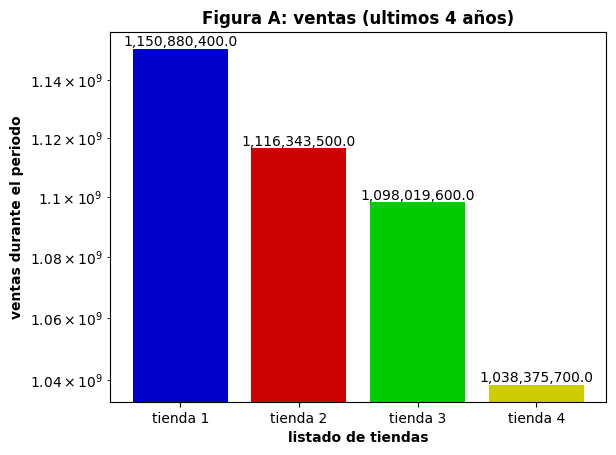

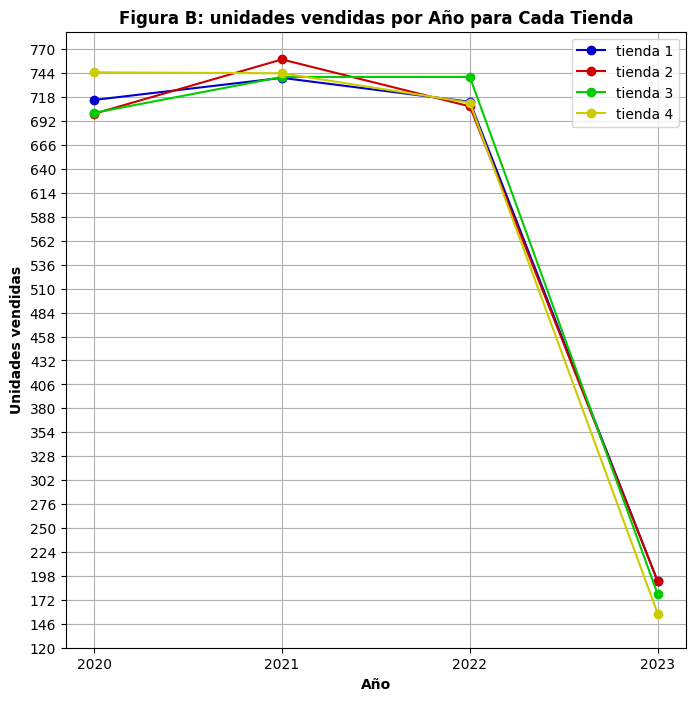

In [95]:
import matplotlib.pyplot as plt
# ventas
ventas = [float(item.ventas()) for item in resultados]
nombres = [item.nombre for item in resultados]
colores = "#0000cc", "#cc0000", "#00cc00", "#cccc00"
plt.bar(nombres, ventas, color=colores)
plt.yscale("log")
for count, item in enumerate(ventas):
  plt.text(count, item, f"{item:,}", ha='center', va='bottom')
plt.title("Figura A: ventas (ultimos 4 años)", fontweight="bold")
plt.ylabel("ventas durante el periodo", fontweight="bold")
plt.xlabel("listado de tiendas", fontweight="bold")
plt.show()

# ventas unitarias por año para cada tienda

plt.figure(figsize=(8, 8))
for hue, tienda, ventas in zip(colores, data_sale_year.keys(), data_sale_year.values()):
    plt.plot(list(ventas.keys()), list(ventas.values()), marker='o', label=tienda, color=hue)
plt.xlabel("Año", fontweight="bold")
plt.ylabel("Unidades vendidas", fontweight="bold")
plt.title("Figura B: unidades vendidas por Año para Cada Tienda", fontweight="bold")
plt.xticks(list(data_sale_year["tienda 1"].keys()))
plt.yticks(np.arange(120, 771, 26))
plt.legend()
plt.grid(True)
plt.show()

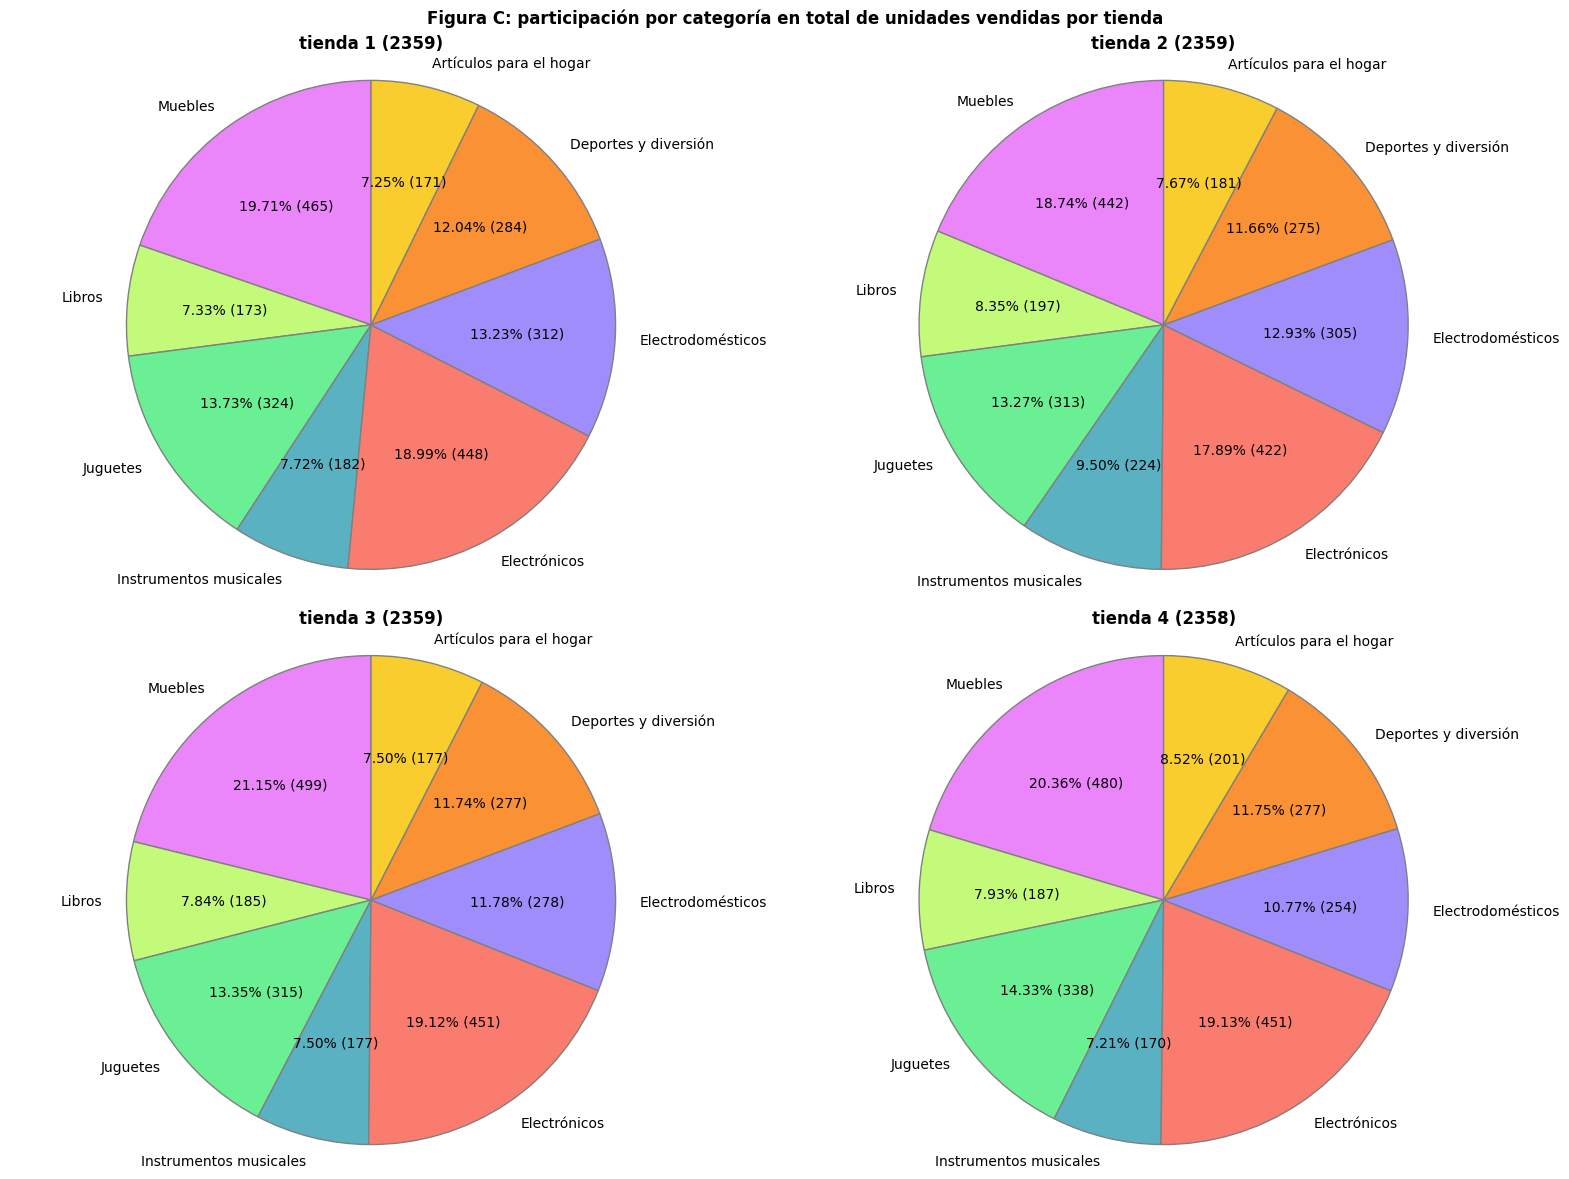

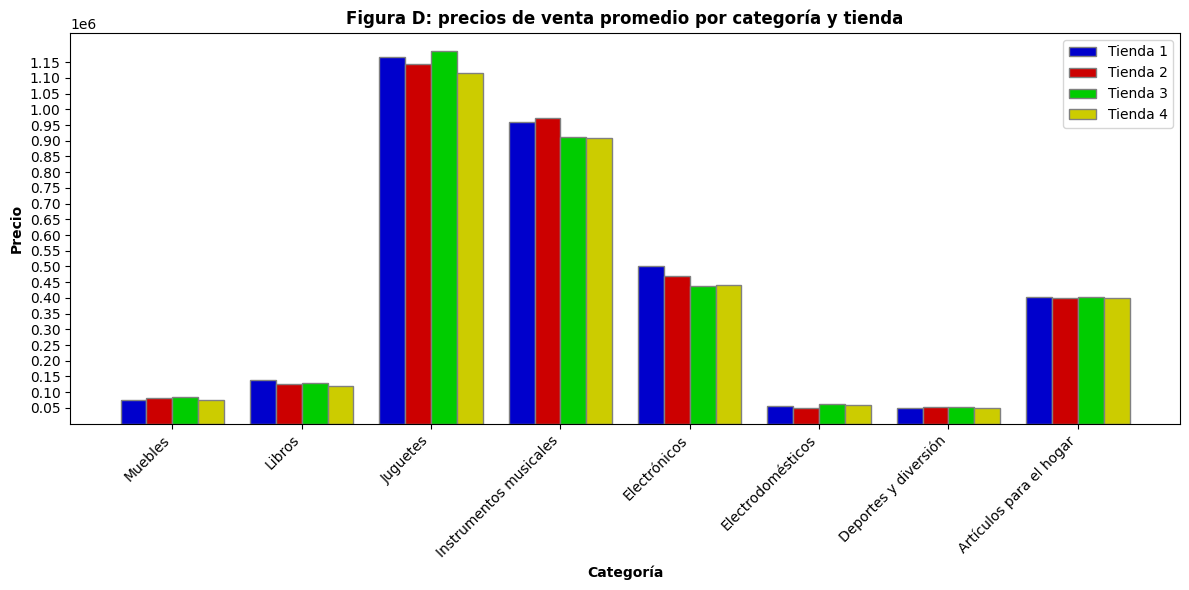

In [94]:

# Datos de ventas por categoría de producto para cada tienda

def auto_pct_format(valores):
    def custom_pct(pct):
        total = sum(valores)
        val = int(round(pct*total/100.0))
        return f"{pct:.2f}% ({val:d})"
    return custom_pct

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

colors = ["#EA85FA", "#C4FA79", "#6AEF94", "#59B1C2", "#FA7C6F", "#9E8DFA", "#FA9135", "#FACD2E"]

for i, (tienda, datos_tienda) in enumerate(current_data_item.items()):
    categorias = list(datos_tienda.keys())
    valores = list(datos_tienda.values())

    row = i // 2
    col = i % 2

    axs[row, col].pie(valores, labels=categorias, autopct=auto_pct_format(valores), startangle=90, colors=colors,
                   wedgeprops={"edgecolor": "gray"})
    axs[row, col].set_title(f"{tienda} ({sum(valores)})", fontweight="bold")
    axs[row, col].axis("equal")
fig.suptitle("Figura C: participación por categoría en total de unidades vendidas por tienda", fontweight="bold")
plt.tight_layout()



try:
  categorías = list(list(data_tienda_mean.values())[0].keys())
except IndexError:
  print("No se pudo generar el grafico")
else:
  ancho_barra = 0.2
  plt.figure(figsize=(12, 6))
  bar_start_positioning_range = np.arange(len(categorías))
  for position, bar_color, tienda_data_mean, dict_value in zip(range(len(colores)), colores, data_tienda_mean.keys(), data_tienda_mean.values()):
    mean_price = list(dict_value.values())
    bar_positioning = [i + ancho_barra*position for i in bar_start_positioning_range]
    plt.bar(bar_positioning, mean_price, color=bar_color, width=ancho_barra, edgecolor="grey", label=tienda_data_mean.title())

  plt.xlabel("Categoría", fontweight="bold")
  plt.ylabel("Precio", fontweight="bold")
  plt.title("Figura D: precios de venta promedio por categoría y tienda", fontweight="bold")
  plt.xticks([r + ancho_barra*1.5 for r in range(len(categorias))], categorias, rotation=45, ha="right")
  plt.yticks(np.arange(50_000, 1_200_000, 50_000))

  plt.legend()

  plt.tight_layout()

  plt.show()

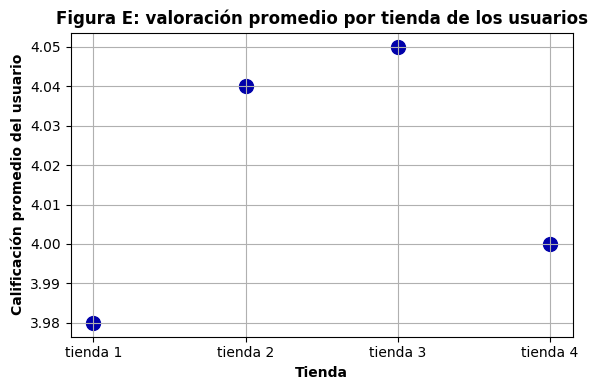

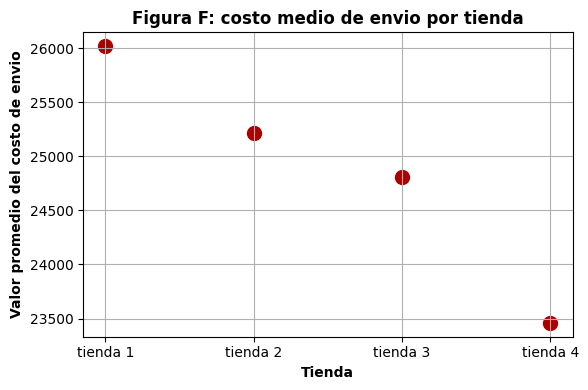

In [96]:
# calificación por tienda
plt.figure(figsize=(6, 4))
plt.scatter(list(opinion_usuario.keys()), list(opinion_usuario.values()), s=100, color="#0000aa")

plt.xlabel("Tienda", fontweight="bold")
plt.ylabel("Calificación promedio del usuario", fontweight="bold")
plt.title("Figura E: valoración promedio por tienda de los usuarios", fontweight="bold")
plt.grid(True)

plt.tight_layout()
plt.show()

# costo de envio promedio por tienda
plt.figure(figsize=(6, 4))
plt.scatter(list(envio_tienda.keys()), list(envio_tienda.values()), s=100, color="#aa0000")

plt.xlabel("Tienda", fontweight="bold")
plt.ylabel("Valor promedio del costo de envio", fontweight="bold")
plt.title("Figura F: costo medio de envio por tienda", fontweight="bold")
plt.grid(True)

plt.tight_layout()
plt.show()


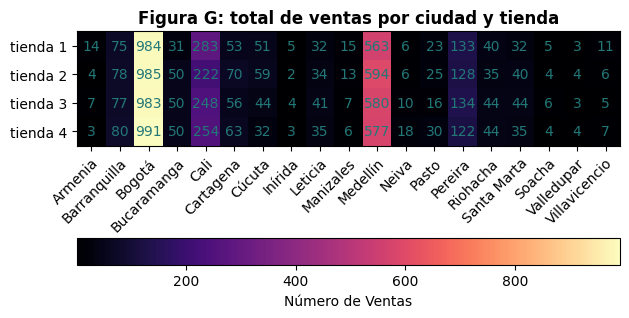

In [97]:
# distribución geografica de ventas

# datos
geographic_data = {}
for tienda_obj in resultados:
  geographic_data[tienda_obj.nombre] = tienda_obj.distribución()["Ciudad de envio compra"]

tiendas_evaluadas = [item.nombre for item in resultados]
if tiendas_evaluadas:
  try:
    ciudades = list(geographic_data[tiendas_evaluadas[0]].keys())
  except KeyError:
    print("No se pudo generar el grafico")
  else:
    datos_matiz = np.array([[val for val in int_dict.values()] for int_dict in geographic_data.values()])
    fig, ax = plt.subplots()
    im = ax.imshow(datos_matiz, cmap="magma")
    cbar = ax.figure.colorbar(im, ax=ax, orientation="horizontal", pad=0.21)
    cbar.ax.set_xlabel("Número de Ventas", rotation=0, va="top")
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(range(len(ciudades)), labels=ciudades,
              rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(tiendas_evaluadas)), labels=tiendas_evaluadas)

    for i in range(len(tiendas_evaluadas)):
        for j in range(len(ciudades)):
            text = ax.text(j, i, datos_matiz[i, j],
                          ha="center", va="center", color="#227777")

    ax.set_title("Figura G: total de ventas por ciudad y tienda", fontweight="bold")
    fig.tight_layout()
    plt.show()

# 9. Analisis de los datos y presentación de resultados

En nuestro intento de poder obtener una respuesta informada a la pregunta ¿cual de las 4 tiendas se deberia cerrar para usar ese dinero en nuevos emprendimientos? se decidio obtener datos con respecto a ingresos (**figura A**), ventas por año (**figura B**), distribución de ventas por categoría de item y promedio de ingresos por categoría (**figuras C y D**),
evaluación de clientes (**figura E**), costo medio de envios (**figura F**) y distribución geografica de ventas (**figura G**). En base a lo anterior se puede observar que datos como los de las **figuras E, F y G** se comportan de forma más o menos uniforme entre las distintas tiendas, por lo que, al no encontrar diferecías significativas en estos datos para determinar el cierre de algun local se decidio por enfocarce en las ventas. Con respecto a ventas se pueden observar diferencias más marcadas entre los ingresos para la **tienda 4** con respecto a todas las demas (**figura A**), dichas menores ventas no se deben especificamente a la cantidad de items vendidos por cada tienda, ya que como se muestra en la **figura B** las ventas por lo general presentan una baja variación entre las tiendas en el periodo 2020-2023, dado lo anterior se espera que las diferencias sean debido no a la cantidad de items vendidos si no al valor individula de cada uno. En la **figura D** se puede apreciar el precio promedio de venta de los items de cada tienda agrupados por categoría, reforzandoce la idea de que algunos items aportan más a las ventas totales con otros, con esto se podría plantear que la **tienda 4** vende menos ya que una mayor proporción de los items vendidos en ella son de menor valor, esta conclución se ve apoyada por los datos de la **figura C** en donde se aprecia que la **tienda 4** posee una mayor proporcion de items vendidos en las categorías de menor valor promedio en comparación con las otras tiendas.

**Resumiendo**, si se considera lo anterior, esto es que las tiendas son homogeneas en lo que es cantidades vendidas totales, valoración de los clientes y distribución geografica de las ventas (al ser tan similares no se arriesga a dejar una tienda con malas reseñas o perderce una ubicación geografica estrategica si nos enfocamos en otros factores) parece acertado enfocarce en donde estan las mayores diferencias, en este caso, las ventas totales las que son marcadamente inferiores en la **tienda 4**.

**Como conclución** seria una decisión acertada cerrar la **tienda 4** dado todo lo anterior expuesto y asi usar ese dinero en inverciones más provechosas.